# 5. Support Vector Machines

*Support Vector Machines (SVMs)* can perform linear/non-linear classification, regression, and outlier detection. They are particularly effective for classification of small-medium datasets.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Linear SVM Classification

**Large Margin Classification**
- Two classes (in $n$ dimensions) are *linearly separable*if there exists a straight line ($(n-1)$-dimensional affine hyperplane) separating them
- Imagine two equidistant parallel lines (hyperplanes) at distance $d$ on either side of the separating line (hyperplane); we call these the *marginns*
- An SVM classifier doing *large margin classification* finds the separating line (hyperplane) with maximum $d$ such that there are no training samples between the margins
- Note that the separating plane is determined by the points that intersect the margins - called *support vectors*
- The separating $n-1$-dimensional hyperplane is the intersection $h(\mathbf{x})=0$ of an $n$-dimensional hyperplane with the feature space and the margins are the hyperplanes $h(\mathbf{x})=\pm 1$
- SVMs are very sensitive to the scales of the features, so you must always use feature scaling
- Large margin only works if the data is linearly separable and even then is very sensitive to outliers

**Soft Margin Classification:** seeks to maximise the distance between margins while limiting (but not necessarily eliminating) *margin violations* (where an instance is on the wrong side of a margin)
- The hyperparameter $C>0$ controls how harshly margin violations are penalised, so smaller $C$ means more regularisation ($C\to\infty$ leads to large margin classification
- SVM classifiers do *not* generate class probabilities, just a prediction
- There are 3 options for linear SVM classifiers: in Scikit-Learn:
    - `LinearSVC`: specialised for linear SVM classifier and is particularly efficient
    - `SVC(kernel="linear")`: general SVM classifier - still scales well with features
    - `SGDClassifier(loss="hinge", alpha=1/(m*C))`: linear SVM classifier via stochastic gradient descent - doesn't converge as fast but allows out-of-core learning

In [2]:
from sklearn import datasets
from sklearn.utils import shuffle

# import iris sample data
iris = datasets.load_iris()

X = pd.DataFrame(data=iris["data"], columns=iris["feature_names"])
y = iris["target"]

# shuffle since data is ordered by class
X, y = shuffle(X, y)

# restrict to binary problem and 2 features
X_petal = X[
    ["petal length (cm)", "petal width (cm)"]
]
y_virg = (y == 2).astype(int)

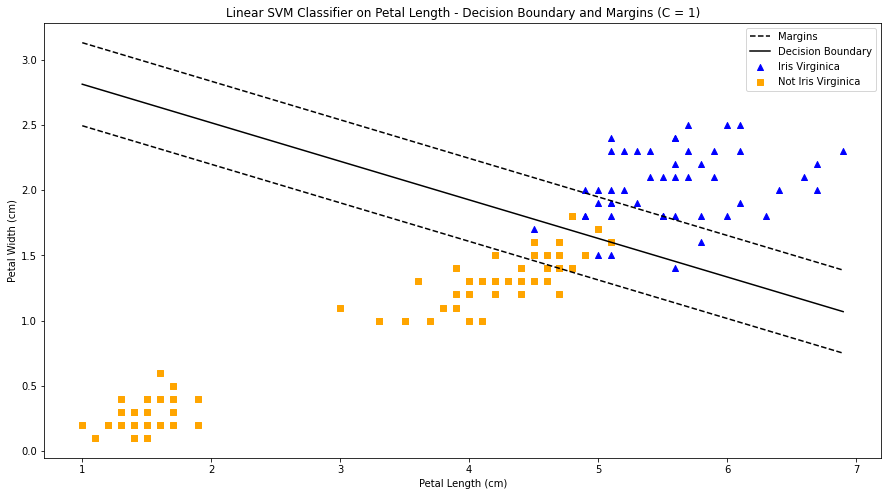

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LinearSVC(C=1, loss="hinge"))
pipe.fit(X_petal, y_virg)

def plot_decision_boundary():
    fig, ax = plt.subplots(figsize=(15, 8))

    def solve_linear_equation(intercept, coef, x, b=0):
        "Solve equation of the form intercept + coef[0]*x + coef[1]*y=b for y"
        y = b - coef[0] * x - intercept
        y /= coef[1]

        return y

    
    scaler = pipe[0]
    lin_svc = pipe[1]
    
    # decision function from SVM
    intercept = lin_svc.intercept_[0]
    coef = lin_svc.coef_[0]
    
    # want to plot intercept + coef[0]*x + coef[1]*y=b for b =-1, 0, 1
    # need to scale x_plot, solve equation for y, then unscale y
    x_plot = np.linspace(
        X_petal["petal length (cm)"].min(), X_petal["petal length (cm)"].max(), 100
    )
    x_plot_scaled = scaler.transform(
        np.c_[x_plot, np.zeros(len(x_plot))] # scaler required array size (*,2) so add a dummy col
    )[:, 0]
    
    for ix, b in enumerate([-1, 0, 1]):
        y_plot_scaled = solve_linear_equation(
            intercept,
            coef,
            x_plot_scaled,
            b
        )
        y_plot = scaler.inverse_transform(
            np.c_[np.zeros(len(y_plot_scaled)), y_plot_scaled]
        )[:, 1]
        
        if b == 0:
            ax.plot(x_plot, y_plot, color="k", ls="-", label="Decision Boundary")
        elif ix == 0:
            ax.plot(x_plot, y_plot, color="k", ls="--", label="Margins")
        else:
            ax.plot(x_plot, y_plot, color="k", ls="--")

    # data points
    ax.scatter(
        X_petal.loc[y_virg == 1, "petal length (cm)"],
        X_petal.loc[y_virg == 1, "petal width (cm)"],
        marker="^",
        color="blue",
        label="Iris Virginica",
    )
    ax.scatter(
        X_petal.loc[y_virg == 0, "petal length (cm)"],
        X_petal.loc[y_virg == 0, "petal width (cm)"],
        marker="s",
        color="orange",
        label="Not Iris Virginica",
    )

    ax.set_xlabel("Petal Length (cm)")
    ax.set_ylabel("Petal Width (cm)")

    ax.set_title("Linear SVM Classifier on Petal Length - Decision Boundary and Margins (C = {})".format(lin_svc.get_params()["C"]))

    ax.legend()


plot_decision_boundary()

## Nonlinear SVM Classification

**Polynomial Kernel:** 
- When the data isn't even close to being linearly separable you can try adding additional (e.g. polynomial) features to transform into a linearly separable space
- Using a *polynomial kernel* is equivalent to adding polynomial features, but doesn't have the downsides of the increase in features (because you don't actually add them)
- This adds 2 extra hyperparameters: `degree` (highest degree polynomials) and `coef0` - a constant in the kernel that determines the impact of high-degree polynomials vs low-degree

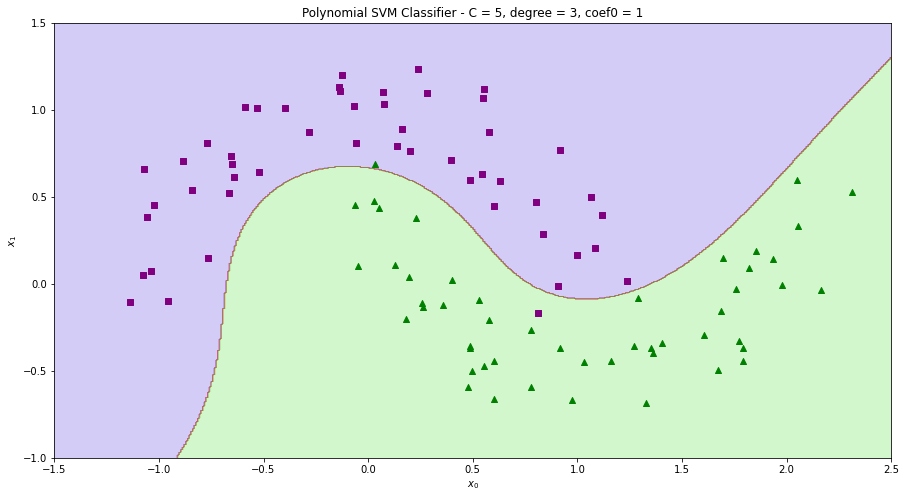

In [4]:
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.base import clone

# generate sample data - 2 interleaving half circles
X, y = make_moons(n_samples=100, noise=0.15)

poly_svc = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_svc.fit(X, y)

def plot_class_predictions(clf, xlim, ylim):
    # generate values along each axis
    x0s = np.linspace(xlim[0], xlim[1], 500)
    x1s = np.linspace(ylim[0], ylim[1], 500)
    
    # all combinations of (x0, x1) for plot
    x0, x1 = np.meshgrid(x0s, x1s)

    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)

    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


def plot_binary_data(X, y):
    plt.scatter(
        X[:, 0][y == 1],
        X[:, 1][y == 1],
        marker="^",
        color="green",
    )
    plt.scatter(
        X[:, 0][y == 0],
        X[:, 1][y == 0],
        marker="s",
        color="purple",
    )


xlim = np.array([-1.5, 2.5])
ylim = np.array([-1, 1.5])

fig, ax = plt.subplots(figsize=(15, 8))

plot_class_predictions(poly_svc, xlim, ylim)
plot_binary_data(X, y)

ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")

ax.set_title("Polynomial SVM Classifier - C = {}, degree = {}, coef0 = {}".format(
    poly_svc["svc"].get_params()["C"],
    poly_svc["svc"].get_params()["degree"],
    poly_svc["svc"].get_params()["coef0"]
));

**Similarity Features:** you can also add features by using a *similarity function* to measure resemblence to a particular *landmark*
- E.g. pick a landmark point $l$ and define a new feature whose value at instance $\mathbf{x}$ is given by  computign the Gaussian *Radial Basis Function* (RBF) for some value of $\gamma$:

\begin{equation}
    \phi_{\gamma}(\mathbf{x}, l) = \exp\left(-\gamma\lVert \mathbf{x}-l\rVert^2\right)
\end{equation}

- $\gamma$ acts as a hyperparameter - decreasign it makes the bell curve around $l$ smoother, so increases regularisation
- The simplest choice of landmark points are just the training points, but this means the same number of features as training points - again we resolve this using kernels

**Gaussian RBF Kernel:** equivalent to adding landmarks at each training point with Gaussian RBF similarity function, but much more computationally efficient
- 2 hyperparameters $\gamma$ and $C$ - decreasing either increases regularisation
- The hyperparameters can take quite a wide range - it's good to do an initial grid search with them taking a wide range of values
- There are other kernels but they're less common
- As a rule of thumb, always use a linear kernel first (particularly if the training set is large). If training set isn't too large, then Gaussian RBF is also often effective

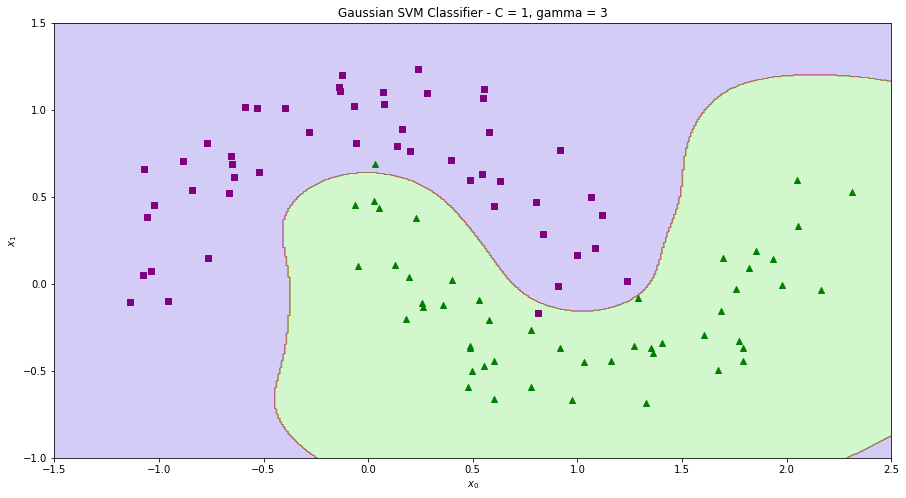

In [5]:
# gaussian rbf kernel on moons data
gauss_svc = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma=3, C=1))
gauss_svc.fit(X, y)

xlim = np.array([-1.5, 2.5])
ylim = np.array([-1, 1.5])

fig, ax = plt.subplots(figsize=(15, 8))

plot_class_predictions(gauss_svc, xlim, ylim)
plot_binary_data(X, y)

ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")

ax.set_title("Gaussian SVM Classifier - C = {}, gamma = {}".format(
    gauss_svc["svc"].get_params()["C"],
    gauss_svc["svc"].get_params()["gamma"],
));

**Multi-class Classification**
- `SVC` uses OvO multiclass classification as default as it doesn't scale well with the training set
- `LinearSVC` uses OvM as default

**Computational Complexity**
- `LinearSVC` scales almost linearly with numbers of features and training instances
- `SVC` supports the kernel trick, but it scales between quadratic and cubic for training instances so isn't practical for large datasets (100,000s)
- `SVC` works well for small-ish  training sets and large numbers of (particularly *sparse*) features

| Class | Time complexity | Out-of-score support | Scaling required | Kernel trick |
|---|---|---|---|---|
| `LinearSVC` | $O(m\times n)$ | No | Yes | No |
| `SGDClassifier` | $O(m\times n)$ | Yes | Yes | No |
| `SVC` | $O(m^2\times n)$ to $O(m^2\times n)$ | No | Yes | Yes |


## SVM Regression

- SVMs can also be used for regression - the algorithm seeks to minimise the number of samples outside the margins, where the distance to the margins is set as a *threshold* hyperparameter $\varepsilon$
- The model is *$\varepsilon$-insensitive* - adding more instances inside the margins doesn't change the model
- As with classification, the data must be scaled and centred
- Essentially everything said for SVM classification also holds for regression

Intercept: 7.69
Coefficient: 1.83


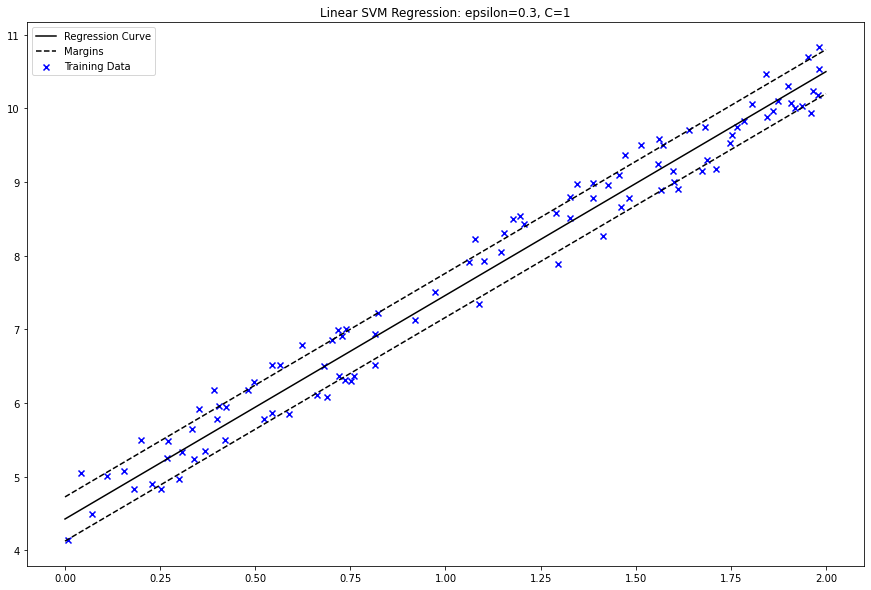

In [6]:
# linear SVR
from sklearn.svm import LinearSVR

# generate some sample data
X = 2 * np.random.rand(100, 1)  # sampled from [0,1) with shape (100, 1)
y = 4 + 3 * X + np.random.rand(100, 1)

# fit model
pipe = make_pipeline(
    StandardScaler(),
    LinearSVR(epsilon=0.3, C=1)
)
pipe.fit(X, y.ravel())

lin_svr = pipe["linearsvr"]
print("Intercept: {:.2f}".format(lin_svr.intercept_[0]))
print("Coefficient: {:.2f}".format(lin_svr.coef_[0]))

# generate data to plot curve
x0 = np.linspace(0, 2, 101)
x0 = np.c_[x0]  # predict expects shape (m, 1), not (m)
y_pred = pipe.predict(x0)

# plot curve against training data
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X, y, color="blue", marker="x", label="Training Data")
ax.plot(x0, y_pred, ls="-", color="k", label="Regression Curve")

# plot margins
epsilon = lin_svr.get_params()["epsilon"]
ax.plot(x0, y_pred + epsilon, ls="--", color="k", label="Margins")
ax.plot(x0, y_pred - epsilon, ls="--", color="k")

ax.set_title("Linear SVM Regression: epsilon={}, C={}".format(epsilon, lin_svr.get_params()["C"]))

ax.legend();

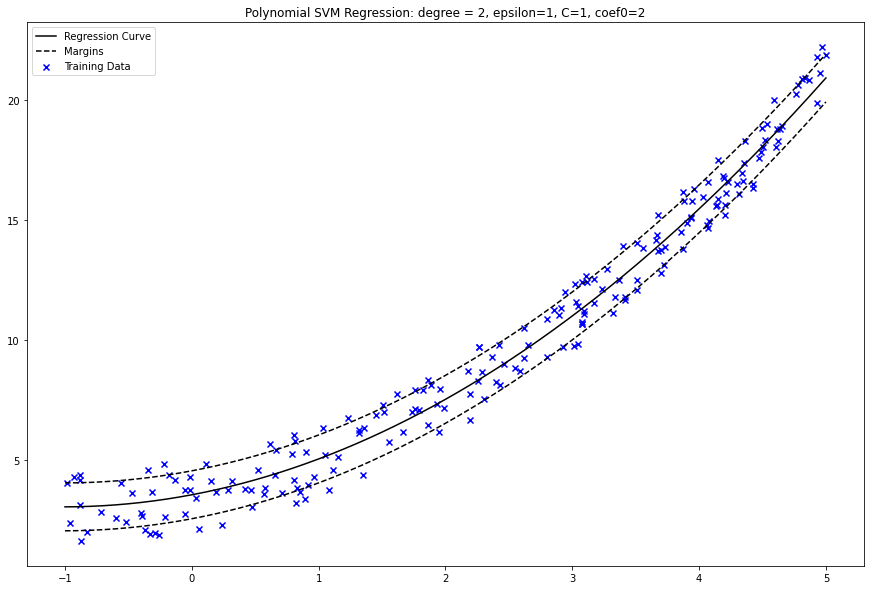

In [11]:
# SVR with polynomial kernel
from sklearn.svm import SVR

# generate some sample data
n_samples = 200
X = 6 * np.random.rand(n_samples, 1) - 1
y = 0.5 * X**2 + X + 2 + 3 * np.random.rand(n_samples, 1)

# fit model
pipe = make_pipeline(
    StandardScaler(), 
    SVR(kernel="poly", degree=2, C=1, epsilon=1, coef0=2) # for some reason this is terrible if coef0=0
)
pipe.fit(X, y.ravel())

# generate data
x0 = np.linspace(-1, 5, 601)
x0 = np.c_[x0]  # predict expects shape (m, 1), not (m)

y_pred = pipe.predict(x0)

# plot curves against training data
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X, y, color="blue", marker="x", label="Training Data")
ax.plot(x0, y_pred, ls="-", color="k", label="Regression Curve")

# plot margins
poly_svr = pipe["svr"]
epsilon = poly_svr.get_params()["epsilon"]
ax.plot(x0, y_pred + epsilon, ls="--", color="k", label="Margins")
ax.plot(x0, y_pred - epsilon, ls="--", color="k")

ax.set_title("Polynomial SVM Regression: degree = {}, epsilon={}, C={}, coef0={}".format(
    poly_svr.get_params()["degree"], epsilon, poly_svr.get_params()["C"], poly_svr.get_params()["coef0"])
)

ax.legend();

## Under the Hood

**Decision Function and Predictions:** the linear SVM classifier has a decision function $\mathbf{w}^T\mathbf{x}+b$ and predicts $\hat{y}=1$ if it's positive, $\hat{y}=0$ if it's negative
- The decision boundary is the line ($(n-1)$-dimensional hyperplane) $\mathbf{w}^T\mathbf{x}+b = 0$ and the margins are the lines $\mathbf{w}^T\mathbf\{x}+b = \pm 1$

**Training Objective:** The goal is to maximise the distance to the margins while avoiding/limiting margin violations
- The slope of the decision function is $\lVert\mathbf{w}\rVert$ so the distance to the margins is $1\big/\lVert\mathbf{w}\rVert$. So to maximise the distance to the margins we need to minimise $\lVert\mathbf{w}\rVert$
- For hard margin classification we need $\mathbf{w}^T\mathbf{x}+b \geq 1$ for all positive instances and $\mathbf{w}^T\mathbf{x}+b\leq -1$ for negative training instaces
- If $t^{(i)}=1$ if $y^{(i)}=1$ and $t^{(i)}=-1$ if $y^{(i)}=0$ then the hard margin optimisation problem  is

\begin{equation}
    \min_{\mathbf{w}, b} \frac{1}{2}\mathbf{w}^T\mathbf{w}
        \qquad \text{ subject to} 
        \quad t^{(i)}\left(\mathbf{w}^T\mathbf{x}^{(i)}+b\right)\geq 1 
        \quad \text{for  } 1\leq i\leq m
\end{equation}

- For soft margin classification we add *slack variables* $\zeta^{(i)}\geq 0$ that describe how much each instance can violate the margin, and add a penalty term to the cost function with hyperparameter $C$:

\begin{equation}
    \min_{\mathbf{w}, b, \mathbf{\zeta}} \frac{1}{2}\mathbf{w}^T\mathbf{w} + C\sum_{i=1}^m\zeta^{(i)}
        \qquad \text{ subject to} 
        \quad t^{(i)}\left(\mathbf{w}^T\mathbf{x}^{(i)}+b\right)\geq 1 - \zeta^{(i)} 
        \quad \text{ and } \zeta^{(i)}\geq 0
        \quad \text{ for  } 1\leq i\leq m
\end{equation}

**Quadratic Programming:** Both hard and soft margin problems are convex quadratic optimisation problems with linear constraints - *Quadratic Programming (QP)* problems
- These can be solved by off-the-shelf QP solvers

**The Dual Problem:** The SVM optimisation problem has a dual problem with the same optimum (see Appendices at the bottom):

\begin{equation}
    \max_{\mathbf{\alpha}} \sum_{i=1}^m \alpha^{(i)} 
            - \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)} (\mathbf{x}^{(i)})^T \mathbf{x}^{(j)}
        \quad \text{subject to} 
        \quad \alpha^{(i)}\geq 0
        \quad \text{for } 1\leq i\leq m.
\end{equation}

- The solution of the primal problem can be deduced from the solution to the dual (see Appendices)
- This is also a QP problem and can be solved using a QP solver
- The dual problem is faster to solve when the number of training instances is smaller than the number of features
- The dual problem is amenable to the kernel trick.

**Kernelised SVMs:** The SVM dual problem only involves the inner product of the feature vectors $\mathbf{x}^{(i)}$, thus if we transform our features via some function $\phi:\mathbb{R}^n\to T$ and then perform SVM classification, we don't actually need to know $\phi(\mathbf{x}^{(i)}$, only the inner products $\phi(\mathbf{x}^{(i)})^T \phi(\mathbf{x}^{(j)})$.

Let $K:\mathbb{R}^n\times\mathbb{R}^n \to \mathbb{R}$ be a positive-definite kernel and let $\phi:\mathbb{R}^n \to l^2(T)$ be a feature mapping such that $K(\mathbf{x}, \mathbf{y}) = \langle \phi(\mathbf{x}),\phi(\mathbf{y})\rangle$ for all $\mathbf{x},\mathbf{y}\in\mathbb{R}^n$ (see Appendix). (I'm going to pretend that all spaces are finite-dimensional and write $\phi(\mathbf{x})^T\phi(\mathbf{y})$ in place of $\langle \phi(\mathbf{x}),\phi(\mathbf{y})\rangle$, for consistency and because the derivation of the dual problem assumes the spaces are finite dimensional *(????)*)
- The dual SVM problem in the new feature space is

\begin{equation}
    \max_{\mathbf{\alpha}} \sum_{i=1}^m \alpha^{(i)} 
            - \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)} K\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}\right)
        \quad \text{subject to} 
        \quad \alpha^{(i)}\geq 0
        \quad \text{for } 1\leq i\leq m.
\end{equation}

- This can still be solved using QP solvers
- We also have $\mathbf{w}=\sum_{i=1}^m \alpha^{(i)} t^{(i)} \phi\left(\mathbf{x}^{(i)}\right)$, so if $S=\lbrace i \,\mid\, 0 < \alpha^{(i)} < C \rbrace$ is the set of indices of support vectors, then

\begin{equation}
   b = \frac{1}{\lvert S\rvert}\sum_{j\in S}\left(t^{(j)} - \mathbf{w}^T \phi\left(\mathbf{x}^{(j)}\right)\right)
       = \frac{1}{\lvert S\rvert}\sum_{j\in S}\left(t^{(i)} - \sum_{i=1}^m \alpha^{(i)} t^{(i)} K\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}\right)\right).
\end{equation}

- Finally, the decision function is

\begin{equation}
    h(\phi(\mathbf{x})) 
        = \mathbf{w}^T \phi(\mathbf{x}) + b
        = \sum_{i=1}^m \alpha^{(i)} t^{(i)} K\left(\mathbf{x}^{(i)}, \mathbf{x}\right) + b.
\end{equation}

- Note that in the last two formulae we only need to sum over $i$ such that $\alpha^{(i)} > 0$, that is indices for support vectors or vectors violating the margins
- The final decision function looks like $\sum a_i K(\mathbf{x}^{(i)}, \cdot) + b$ for some constants $a_i$ summed over support/violating vectors. This is an *instance-based model*: the model needs to remember a subset of the training instances (the rest can be throw away after training) and each new input is compared with the training instances $\mathbf{x}^{(i)}$ using the similarity function $K(\mathbf{x}^{(i)}, \cdot)$
- Common kernels:

\begin{align}
    \text{Linear:} &  \qquad K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \mathbf{b} \\
    \text{Polynomial:} & \qquad  K(\mathbf{a}, \mathbf{b}) = \left(\gamma\mathbf{a}^T \mathbf{b} + r\right)^d \\
    \text{Gaussian RBF:} & \qquad  K(\mathbf{a}, \mathbf{b}) = \exp\left(-\gamma\lVert \mathbf{a} - \mathbf{b}\rVert^2\right) \\
    \text{Sigmoid:} & \qquad  K(\mathbf{a}, \mathbf{b}) = \tanh\left(\gamma\mathbf{a}^T \mathbf{b} + r\right) \\
\end{align}

- It isn't clear to me that this kernel trick is exactly the same as replacing the original features with a similarity function with all training instances as landmarks, but they're clearly interconnected

**Online SVMs:** SVM classifiers can learn incrementally by using gradient descent (e.g. through `SGCClassifier`) to minimise the unconstrained cost function:

\begin{equation}
    J(\mathbf{w}, b) = \frac{1}{2} \lVert \mathbf{w}\rVert^2 + C \sum_{i=1}^m \max\left(0, 1 - t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b)\right)
\end{equation}

- This is slower than QP methods
- There are implementations of online SVMs that allow non-linear kernels, but it isn't clear if there are any for python - neural networks are probably better for large-scale non-linear problems

# Appendix

## Dual Problems in Optimisation

This comes from Chapter 5 of [Convex Optimization](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf) by Boyd and Vandenberghe.

Consider an optimisation problem of the form $\min_{x} f_0(x)$ subject to $f_i(x)\geq 0$ for $1\leq i\leq m$, where $x\in\mathbb{R}^n$. We call this the *primal problem*, $f_0$ the *objective function*, and $f_i(x)\geq 0$ the *inequality constraints*. Let $p^*$ be the optimal value of the primal problem. We call $\tilde{x}$ *primal feasible* if it satisfies the inequality constraints. We call it *primal optimal* if it is primal feasible and it achives the optimal value: $f_0(\tilde{x})=p^*$.

The *Lagrangian* is

\begin{equation}
    \mathscr{L}(x, \alpha) = f_0(x) - \sum_{i=1}^m \alpha_i f_i(x),
\end{equation}

where the $\alpha_i$ are called *Lagrange mutlipliers*. The *Lagrange dual function* is $g(\alpha) = \inf_x \mathscr{L}(x, \alpha)$. The *Lagrange dual problem* is $\max_{\alpha} g(\alpha)$ subject to $\alpha_i\geq 0$ for $1\leq i\leq m$. Let $d^*$ be the optimal value of the dual problem. We call $\tilde{\alpha}$ *dual feasible* if it satisfies the inequality constraints $\tilde{\alpha}_i\geq 0$. We call it *dual optimal* if it is dual feasible and it achives the optimal value: $g_(\tilde{\alpha})=d^*$. The dual problem is convex even if the primal problem isn't.

For any dual feasible $\tilde{\alpha}$, we have $g(\alpha)\leq p^*$. In particular, we have *weak duality*: $g^*\leq p^*$. The difference $p^*-g^*$ is called the *optimal duality gap*. We say *strong duality* holds if $g^*=p^*$. 

**Slater's Theorem:** If the primary problem is convex, the inequality constraints are all affine functions, and there exist a primal feasible vector then strong duality holds. (This is actually a special case of the theorem)

Now assume the $f_i$ are all differentiable.

**Karush-Kuhn-Tucker (KKT) Conditions:**
\begin{equation}
    f_i(x) \geq 0 ~ (\forall i>0),\qquad
    \alpha_i \geq 0 ~ (\forall i>0),\qquad
    \alpha_i f_i(x) = 0 ~ (\forall i>0),\qquad
    \nabla_x \mathscr{L}(x, \alpha) = 0.
\end{equation}

Note that the first two conditions just state that $x$ and $\alpha$ and primal and dual feasible, respectively. The penultimate condition is known as *complementary slackness*. It means that for each $i>0$, either $\alpha_i$ or $f_i(x)$ is zero.

**Theorem:** If strong duality holds and $\tilde{x}$ and $\tilde{\alpha}$ are primal and dual optimal respectively, then the KKT conditions hold at $(\tilde{x}, \tilde{\alpha})$. Moreover, if the KKT conditions hold at $(\tilde{x}, \tilde{\alpha})$ and the primal problem is convex, then $\tilde{x}$ and $\tilde{\alpha}$ are primal and dual optimal.

## The SVM Dual Problem

This follows Appendix C in the textbook, though they only deal with hard margin classification. Below we cover the soft margin classification problem:

\begin{equation}
    \min_{\mathbf{w}, b, \mathbf{\zeta}} \frac{1}{2}\mathbf{w}^T\mathbf{w} + C\sum_{i=1}^m\zeta^{(i)}
        \quad \text{ subject to} \quad
        \quad t^{(i)}\left(\mathbf{w}^T\mathbf{x}^{(i)}+b\right) + \zeta^{(i)} - 1 \geq 0
        \quad \text{ and } \quad \zeta^{(i)}\geq 0
        \quad \text{ for  } \quad 1\leq i\leq m.
\end{equation}

This is a convex optimisation problem with $2m$ affine inequality constraints. In particular, Slater's Theorem holds, so strong duality holds, and the (strong form of the) KKT Theorem holds.

The Lagrangian is

\begin{align}
    \mathscr{L}(\mathbf{w}, b, \mathbf{\zeta}, \mathbf{\alpha}, \mathbf{\beta})
        & = \frac{1}{2} \mathbf{w}^T \mathbf{w} 
            + C \sum_{i=1}^m \zeta^{(i)} 
            - \sum_{i=1}^m \alpha^{(i)}\left(t^{(i)}\left(\mathbf{w}^T\mathbf{x}^{(i)} + b\right) + \zeta^{(i)} - 1 \right)
            - \sum_{i=1}^m \beta^{(i)} \zeta^{(i)} \\
        & = \frac{1}{2} \mathbf{w}^T \mathbf{w} 
            - \sum_{i=1}^m \alpha^{(i)} t^{(i)} \mathbf{w}^T \mathbf{x}^{(i)}
            - \left(\sum_{i=1}^m \alpha^{(i)} t^{(i)}\right) b
            + \sum_{i=1}^m \left( C - \alpha^{(i)} - \beta^{(i)}\right) \zeta^{(i)} 
            + \sum_{i=1}^m \alpha^{(i)},
\end{align}

where $\alpha^{(i)}$ and $\beta^{(i)}$ are Langrange multipliers for $1\leq i\leq m$.

The gradient of $\mathscr{L}$ can be broken down into

\begin{equation}
    \nabla_{\mathbf{w}} \mathscr{L} = \mathbf{w} - \sum_{i=1}^m \alpha^{(i)} t^{(i)} \mathbf{x}^{(i)}, \qquad
    \nabla_{b} \mathscr{L} = -\sum_{i=1}^m \alpha^{(i)} t^{(i)}, \quad \text{and} \quad
    \nabla_{\mathbf{\zeta}} \mathscr{L} = C - \mathbf{\alpha} - \mathbf{\beta}.
\end{equation}

By the KKT conditions, these are equal to zero at any optimum of the problems, so

\begin{equation}
    \mathbf{w} = \sum_{i=1}^m \alpha^{(i)} t^{(i)} \mathbf{x}^{(i)}, \qquad
    \sum_{i=1}^m \alpha^{(i)} t^{(i)} = 0, \quad \text{and} \quad
    \mathbf{\beta} = C - \mathbf{\alpha}.
\end{equation}

Substituting this into the Langrangian it becomes

\begin{equation}
    g(\mathbf{\alpha}) = 
        \sum_{i=1}^m \alpha^{(i)} 
            - \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)} \mathbf{x}^{(i)} \mathbf{x}^{(j)}.
\end{equation}

Thus the dual problem is $\max_{\mathbf{\alpha}} g(\alpha)$ subject to $\alpha^{(i)} \geq 0$ for $i > 0$. This is a convex problem and can be solved by QP solvers.

At the optimal values, the other KKT conditions must also hold: $\alpha^{(i)}\geq 0$, $\beta^{(i)}\geq 0$, $\zeta^{(i)}\geq 0$, $t^{(i)}\left(\mathbf{w}^T\mathbf{x}^{(i)}+b\right) + \zeta^{(i)} - 1 \geq 0$, the complementary slackness conditions

\begin{equation}
    \alpha^{(i)}\left(t^{(i)}\left(\mathbf{w}^T\mathbf{x}^{(i)}+b\right) + \zeta^{(i)} - 1\right) = 0
        \quad \text{and} \quad \beta^{(i)} \zeta^{(i)} = 0,
\end{equation}

and the equalities above resulting from $\nabla \mathscr{L} = 0$. In particular we can still calculate $\mathbf{w}$ from $\alpha^{(i)}$. We also get 3 cases:

1. If $\alpha^{(i)} = 0$ then $\beta^{(i)} = C \neq 0$ so $\zeta^{(i)} = 0$ and we just have the hard classification condition: $t^{(i)}\left(\mathbf{w}^T\mathbf{x}^{(i)}+b\right) \geq 1$. This means that the instance $\mathbf{x}^{(i)}$ lies outside the margins.

2. If $0 < \alpha^{(i)} < C$ then $\beta^{(i)} \neq 0$ so $\zeta^{(i)} = 0$ and complementary slackness forces equality: $t^{(i)}\left(\mathbf{w}^T\mathbf{x}^{(i)}+b\right) = 1$. This means that $\mathbf{x}^{(i)}$ is a support vector. We can calculate $b$ from $b=\frac{1}{\lvert S\rvert}\sum_{i\in S}\left(t^{(i)} - \mathbf{w}^T \mathbf{x}^{(i)}\right)$, where $S=\lbrace i \,\mid\, 0 < \alpha^{(i)} < C \rbrace$ is the set of indices of support vectors (we could actually use any single support vector, but in practice we are estimating so this is more accurate). (It is possible that $S=\emptyset$. In this case the  SVM problem is called *degenerate* and the optimal solution if $\mathbf{w} = 0$ - see [A Note on Support Vector Machines Degeneracy](https://dspace.mit.edu/handle/1721.1/7291). If this is the case just reduce $C$).

3. If $\alpha^{(i)} = C$ then $\beta^{(i)} = 0$, so we still have the inequality $\zeta^{(i)}\geq 0$ and hence the equality: $t^{(i)}\left(\mathbf{w}^T\mathbf{x}^{(i)}+b\right) = 1 - \zeta^{(i)}$. This means that $\mathbf{x}^{(i)}$ is on the wrong side of the margins.

From this we deduce that

\begin{equation}
    \zeta^{(i)} = \begin{cases}
        0 & \text{if } t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \geq 1, \\
        1 - t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) & \text{if } t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) < 1,
    \end{cases}
\end{equation}

or in closed form

\begin{equation}
    \zeta^{(i)} = \max\left(0, 1 - t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b)\right).
\end{equation}

The function $h(t) = \max(0, 1-t)$ is known as the *hinge loss function*. This allows us to obtain the *unconstrained formulation* of the SVM cost function:

\begin{equation}
    J(\mathbf{w}, b) = \frac{1}{2} \lVert \mathbf{w}\rVert^2 + C \sum_{i=1}^m \max\left(0, 1 - t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b)\right).
\end{equation}

This is a combination of an $l_2$ regulariser and a hinge loss function. The regulariser pushes the model to have a larger margin. The hinge loss function adds a scaler multiple of all margin violations. Note that as with Loess regression, the hinge loss function tends towards setting terms to zero, i.e. minimising margin violations.

## Kernels

This uses [Positive Definite Kernels in Machine Learning](https://arxiv.org/pdf/0911.5367.pdf).

Let $\mathcal{X}$ be a non-empty set. A *positive-definite kernel* on $\mathcal{X}$ is a symmetric function $K:\mathcal{X}\times\mathcal{X} \longrightarrow \mathbb{R}$ such that

\begin{equation}
    \sum_{i,j=1}^n c_i c_j K(x_i, x_j)\geq 0
\end{equation}

for any $n\in\mathbb{N}$, $x_i\in\mathcal{X}$, and $c_i\in\mathbb{R}$.

Theorem 1 in §2.3 shows positive-definite kernels are exactly dot products of feature representations: A function $K$ on $\mathcal{X}\times\mathcal{X}$ is a positive-definite kernel if and only if there exists a set $T$ and a mapping $\phi:\mathcal{X}\to l^2 (T)$ such that

\begin{equation}
    K(x, y) = \sum_{t\in T}\phi(x)_t \phi(y)_t = \langle \phi(x), \phi(y)\rangle_{l^2}
    .
\end{equation}